In [1]:
import numpy as np
import os,sys
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
from astropy.io import fits
import matplotlib.pyplot as plt


#if you want to rerun all tests below from scratch
# overwrite = True
overwrite = False

# How to get quaternion data

In [2]:
def get_qdata(SectorNumber, savepath, overwrite=False):
    """
    Downloads or loads the quaternion data for the specified TESS sector.
    
    Parameters:
    - SectorNumber: int, TESS sector number
    - savepath: str, path to save or load quaternion data
    - overwrite: bool, whether to overwrite existing quaternion data file
    
    Returns:
    - qdata: FITS file object containing quaternion data
    """
    mast_url = 'https://archive.stsci.edu/missions/tess/engineering/'

    # Dictionary mapping sectors to filenames
    s_dict = {
        'S1':'tess2018331094053_sector01-quat.fits',
        'S2':'tess2018330083923_sector02-quat.fits',
        'S3':'tess2018344131939_sector03-quat.fits',
        'S4':'tess2018344132117_sector04-quat.fits',
        'S5':'tess2019024141334_sector05-quat.fits',
        'S6':'tess2019050105252_sector06-quat.fits',
        'S7':'tess2019050113148_sector07-quat.fits',
        'S8':'tess2019060083045_sector08-quat.fits',
        'S9':'tess2019093074938_sector09-quat.fits',
        'S10':'tess2019136122405_sector10-quat.fits',
        'S11':'tess2019140185400_sector11-quat.fits',
        'S12':'tess2019170120618_sector12-quat.fits',
        'S13':'tess2019207131829_sector13-quat.fits',
        'S14':'tess2019227202023_sector14-quat.fits',
        'S15':'tess2019255102657_sector15-quat.fits',
        'S16':'tess2019280102352_sector16-quat.fits',
        'S17':'tess2019307010433_sector17-quat.fits',
        'S18':'tess2019331203517_sector18-quat.fits',
        'S19':'tess2019357232015_sector19-quat.fits',
        'S20':'tess2020021235438_sector20-quat.fits',
        'S21':'tess2020052075303_sector21-quat.fits',
        'S22':'tess2020081142848_sector22-quat.fits',
        'S23':'tess2020107160812_sector23-quat.fits',
        'S24':'tess2020153133807_sector24-quat.fits',
        'S25':'tess2020161111146_sector25-quat.fits',
        'S26':'tess2020188185629_sector26-quat.fits'
    }

    filename = os.path.join(savepath, f'Sector_{SectorNumber}_quaternion_data.fits')
    
    if not os.path.isfile(filename) or overwrite:
        print('Downloading quaternion data from MAST...')
        qdata = fits.open(mast_url + s_dict[f'S{SectorNumber}'])
        qdata.writeto(filename, overwrite=True)
    else:
        print(f'{filename} exists! Loading...')
        qdata = fits.open(filename)
    return qdata

def make_qdata_df(qdata, Camera):
    """
    Converts quaternion data from a FITS file to a pandas DataFrame for a specific camera.
    
    Parameters:
    - qdata: FITS file object containing quaternion data
    - Camera: int, camera number (1 to 4)
    
    Returns:
    - qdataCam_df: DataFrame with quaternion data for the specified camera
    """
    from astropy.table import Table
    qdataCam_df = Table(qdata[Camera].data).to_pandas()
    return qdataCam_df


SectorNumber = 1
Camera = 1
savepath = os.getcwd()+'/quaternion_data/'
# Step 2: Load and Process Quaternion Data
quaternion_data = make_qdata_df(qdata = get_qdata(SectorNumber, savepath, overwrite),
                                Camera=Camera)
quaternion_data.head(1)

/Users/daxfeliz/Desktop/TESS/00_Current_Pipeline/test_new_features/step_3_removing_bad_data/quaternion_data/Sector_1_quaternion_data.fits exists! Loading...


,TIME,C1_FOM,C1_NUM_GSUSED,C1_NUM_MSTOT,C1_Q1,C1_Q2,C1_Q3,C1_Q4,C1_Q1_SC,C1_Q2_SC,C1_Q3_SC,C1_Q4_SC
0,1325.292823,236.0,199.0,200.0,0.000047,-0.000027,-0.000036,1.0,0.000043,0.000047,-0.000013,1.0


# What do quaternions look like?


In [3]:
def generate_q_mask_overall_ALT(qdata, Camera, Nstd):
    
    qdataCam_df=make_qdata_df(qdata, Camera=Camera)
    qtimeCN,qquat_CNQ1=make_qdata_arr(qdataCam_df,Camera=Camera,Qnum=1,return_time=True)
    qquat_CNQ2 =       make_qdata_arr(qdataCam_df,Camera=Camera,Qnum=2,return_time=False)
    qquat_CNQ3 =       make_qdata_arr(qdataCam_df,Camera=Camera,Qnum=3,return_time=False)
    
    #sort by time
    qquat_CNQ1 = qquat_CNQ1[np.argsort(qtimeCN)]
    qquat_CNQ2 = qquat_CNQ2[np.argsort(qtimeCN)]
    qquat_CNQ3 = qquat_CNQ3[np.argsort(qtimeCN)]
    
    #qquat_CNQ4 =       make_qdata_arr(qdataCam_df,Camera=Camera,Qnum=4,return_time=False)  \    
#     try:
#         q1_c= qdata[Camera].data['C'+str(Camera)+'_Q1'].byteswap().newbyteorder() #roll,  i-hat
#         q2_c= qdata[Camera].data['C'+str(Camera)+'_Q2'].byteswap().newbyteorder() #pitch, j-hat
#         q3_c= qdata[Camera].data['C'+str(Camera)+'_Q3'].byteswap().newbyteorder() #yaw,   k-hat
#         q4_c= qdata[Camera].data['C'+str(Camera)+'_Q4'].byteswap().newbyteorder() #scalar component
#     except AttributeError:
#         q1_c= qdata[Camera].data['C'+str(Camera)+'_Q1'] #roll,  i-hat
#         q2_c= qdata[Camera].data['C'+str(Camera)+'_Q2'] #pitch, j-hat
#         q3_c= qdata[Camera].data['C'+str(Camera)+'_Q3'] #yaw,   k-hat
#         q4_c= qdata[Camera].data['C'+str(Camera)+'_Q4'] #scalar component
    # Generate mask based on those above Nstd
    q_mask1 = np.abs(qquat_CNQ1) < Nstd*np.nanstd(qquat_CNQ1)
    q_mask2 = np.abs(qquat_CNQ2) < Nstd*np.nanstd(qquat_CNQ2)
    q_mask3 = np.abs(qquat_CNQ3) < Nstd*np.nanstd(qquat_CNQ3)
    #q_mask4 = np.abs(qquat_CNQ4) < Nstd*np.nanstd(qquat_CNQ4)
    # don't use scalar in mask, only vector components
    q_mask_overall = (q_mask1 == True) & (q_mask2 == True) & (q_mask3 == True) #& (q_mask4 == True) 
    return q_mask_overall
    


def plot_qdata(qdata,Camera,Qnum,mrkcol,ax,show_good_data,Nstd=None):
    qdataCam_df=make_qdata_df(qdata, Camera=Camera)
    qtimeCN,qquat_CNQN=make_qdata_arr(qdataCam_df,Camera=Camera,Qnum=Qnum,return_time=True)        
    ax.plot(qtimeCN, qquat_CNQN-np.nanmean(qquat_CNQN), mrkcol,markersize=5)
    ax.set_xlim(np.nanmin(qtimeCN)-2, np.nanmax(qtimeCN)+2)
    if show_good_data==True:
        if type(Nstd)==type(None):
            q_mask_overall =generate_q_mask_overall_ALT(qdata,Camera,Nstd=3)
        else:
            q_mask_overall =generate_q_mask_overall_ALT(qdata,Camera,Nstd=Nstd)
        x=qtimeCN[q_mask_overall]
        y=(qquat_CNQN-np.nanmean(qquat_CNQN))[q_mask_overall]
        ax.plot(x,y,linestyle='none',color='grey',
                marker='.',label=str(Nstd)+r'$\sigma$ clipped Quaternion Data',
                markersize=3)

def make_qdata_arr(qdataCam_df,Camera,Qnum,return_time=False):
    
    qquat = qdataCam_df['C'+str(Camera)+'_Q'+str(Qnum)].to_numpy()
    if return_time==True:
        qtime = qdataCam_df['TIME'].to_numpy()
        return qtime,qquat
    if return_time==False:
        return qquat        

def set_up_quaternion_directory_and_plots(pipelinepath, maxSectorNumber, 
                                          overwrite_plots,show_good_data, 
                                          Nstd=None):
    # Step 0: create directory for quaternion data
    savepath=pipelinepath#+'TESS_Quaternion_data/'
    if os.path.exists(savepath)==True:
        pass
    else:
        os.makedirs(savepath)                
    ###
    def make_quaternion_plots_with_momentum_dumps(qdata,savepath,
                                                  SectorNumber, mdump_times,
                                                  show_good_data,Nstd):
        fig, axes = plt.subplots(nrows=4, ncols=4,figsize=(10,10))

        ax11 = axes[0][0]
        ax12 = axes[1][0]
        ax13 = axes[2][0]
        ax14 = axes[3][0]

        ax21 = axes[0][1]
        ax22 = axes[1][1]
        ax23 = axes[2][1]
        ax24 = axes[3][1]

        ax31 = axes[0][2]
        ax32 = axes[1][2]
        ax33 = axes[2][2]
        ax34 = axes[3][2]

        ax41 = axes[0][3]
        ax42 = axes[1][3]
        ax43 = axes[2][3]
        ax44 = axes[3][3]
        
        if show_good_data == True:
            if Nstd==None:
                Nstd=3
        Camera=1        
        plot_qdata(qdata,Camera=1,Qnum=1,mrkcol='k.',ax=ax11,show_good_data=show_good_data,Nstd=Nstd)
        plot_qdata(qdata,Camera=1,Qnum=2,mrkcol='r.',ax=ax12,show_good_data=show_good_data,Nstd=Nstd)
        plot_qdata(qdata,Camera=1,Qnum=3,mrkcol='g.',ax=ax13,show_good_data=show_good_data,Nstd=Nstd)
        plot_qdata(qdata,Camera=1,Qnum=4,mrkcol='b.',ax=ax14,show_good_data=show_good_data,Nstd=Nstd)
        ax11.set_title('C'+str(Camera)+' Q1')
        ax12.set_title('C'+str(Camera)+' Q2')
        ax13.set_title('C'+str(Camera)+' Q3')
        ax14.set_title('C'+str(Camera)+' Q4')
        if mdump_times is not None:
            for m in mdump_times:
                ax11.axvline(x=m,color='cyan',zorder=-10,linewidth=3)
                ax12.axvline(x=m,color='cyan',zorder=-10,linewidth=3)
                ax13.axvline(x=m,color='cyan',zorder=-10,linewidth=3)
                ax14.axvline(x=m,color='cyan',zorder=-10,linewidth=3)
        ax11.set_ylabel(r'$\Delta$X = Q1')
        ax12.set_ylabel(r'$\Delta$Y = Q2')
        ax13.set_ylabel(r'$\Delta$Z = Q3')
        ax14.set_ylabel(r'??? = Q4')
        ax14.set_xlabel('Time [BTJD]')
        
        Camera=2
        plot_qdata(qdata,Camera=2,Qnum=1,mrkcol='k.',ax=ax21,show_good_data=show_good_data,Nstd=Nstd)
        plot_qdata(qdata,Camera=2,Qnum=2,mrkcol='r.',ax=ax22,show_good_data=show_good_data,Nstd=Nstd)
        plot_qdata(qdata,Camera=2,Qnum=3,mrkcol='g.',ax=ax23,show_good_data=show_good_data,Nstd=Nstd)
        plot_qdata(qdata,Camera=2,Qnum=4,mrkcol='b.',ax=ax24,show_good_data=show_good_data,Nstd=Nstd)
        ax21.set_title('C'+str(Camera)+' Q1')
        ax22.set_title('C'+str(Camera)+' Q2')
        ax23.set_title('C'+str(Camera)+' Q3')
        ax24.set_title('C'+str(Camera)+' Q4')
        if mdump_times is not None:
            for m in mdump_times:
                ax21.axvline(x=m,color='cyan',zorder=-10,linewidth=3)
                ax22.axvline(x=m,color='cyan',zorder=-10,linewidth=3)
                ax23.axvline(x=m,color='cyan',zorder=-10,linewidth=3)
                ax24.axvline(x=m,color='cyan',zorder=-10,linewidth=3)
        ax21.set_ylabel(r'$\Delta$X = Q1')
        ax22.set_ylabel(r'$\Delta$Y = Q2')
        ax23.set_ylabel(r'$\Delta$Z = Q3')
        ax24.set_ylabel(r'??? = Q4')                
        ax24.set_xlabel('Time [BTJD]')
        
        Camera=3
        plot_qdata(qdata,Camera=3,Qnum=1,mrkcol='k.',ax=ax31,show_good_data=show_good_data,Nstd=Nstd)
        plot_qdata(qdata,Camera=3,Qnum=2,mrkcol='r.',ax=ax32,show_good_data=show_good_data,Nstd=Nstd)
        plot_qdata(qdata,Camera=3,Qnum=3,mrkcol='g.',ax=ax33,show_good_data=show_good_data,Nstd=Nstd)
        plot_qdata(qdata,Camera=3,Qnum=4,mrkcol='b.',ax=ax34,show_good_data=show_good_data,Nstd=Nstd)
        ax31.set_title('C'+str(Camera)+' Q1')
        ax32.set_title('C'+str(Camera)+' Q2')
        ax33.set_title('C'+str(Camera)+' Q3')
        ax34.set_title('C'+str(Camera)+' Q4')
        if mdump_times is not None:
            for m in mdump_times:
                ax31.axvline(x=m,color='cyan',zorder=-10,linewidth=3)
                ax32.axvline(x=m,color='cyan',zorder=-10,linewidth=3)
                ax33.axvline(x=m,color='cyan',zorder=-10,linewidth=3)
                ax34.axvline(x=m,color='cyan',zorder=-10,linewidth=3)
        ax31.set_ylabel(r'$\Delta$X = Q1')
        ax32.set_ylabel(r'$\Delta$Y = Q2')
        ax33.set_ylabel(r'$\Delta$Z = Q3')
        ax34.set_ylabel(r'??? = Q4')                
        ax34.set_xlabel('Time [BTJD]')
        
        Camera=4
        plot_qdata(qdata,Camera=4,Qnum=1,mrkcol='k.',ax=ax41,show_good_data=show_good_data,Nstd=Nstd)
        plot_qdata(qdata,Camera=4,Qnum=2,mrkcol='r.',ax=ax42,show_good_data=show_good_data,Nstd=Nstd)
        plot_qdata(qdata,Camera=4,Qnum=3,mrkcol='g.',ax=ax43,show_good_data=show_good_data,Nstd=Nstd)
        plot_qdata(qdata,Camera=4,Qnum=4,mrkcol='b.',ax=ax44,show_good_data=show_good_data,Nstd=Nstd)
        ax41.set_title('C'+str(Camera)+' Q1')
        ax42.set_title('C'+str(Camera)+' Q2')
        ax43.set_title('C'+str(Camera)+' Q3')
        ax44.set_title('C'+str(Camera)+' Q4')
        if mdump_times is not None:
            for m in mdump_times:
                ax41.axvline(x=m,color='cyan',zorder=-10,linewidth=3)
                ax42.axvline(x=m,color='cyan',zorder=-10,linewidth=3)
                ax43.axvline(x=m,color='cyan',zorder=-10,linewidth=3)
                ax44.axvline(x=m,color='cyan',zorder=-10,linewidth=3)
        ax41.set_ylabel(r'$\Delta$X = Q1')
        ax42.set_ylabel(r'$\Delta$Y = Q2')
        ax43.set_ylabel(r'$\Delta$Z = Q3')
        ax44.set_ylabel(r'??? = Q4')                
        ax44.set_xlabel('Time [BTJD]')    
        
        ax11.ticklabel_format(useOffset=False)
        ax12.ticklabel_format(useOffset=False)
        ax13.ticklabel_format(useOffset=False)
        ax14.ticklabel_format(useOffset=False)
        ax21.ticklabel_format(useOffset=False)
        ax22.ticklabel_format(useOffset=False)
        ax23.ticklabel_format(useOffset=False)
        ax24.ticklabel_format(useOffset=False)        
        ax31.ticklabel_format(useOffset=False)
        ax32.ticklabel_format(useOffset=False)
        ax33.ticklabel_format(useOffset=False)
        ax34.ticklabel_format(useOffset=False)        
        ax41.ticklabel_format(useOffset=False)
        ax42.ticklabel_format(useOffset=False)
        ax43.ticklabel_format(useOffset=False)
        ax44.ticklabel_format(useOffset=False)        
        
        fig.tight_layout(pad=1)
        filename = savepath+ 'Sector_'+str(int(SectorNumber)) + '_quaternion_data.png'
        fig.savefig(filename)
        plt.show()
        
        
        
    mdump_times= pd.read_csv('https://tess.mit.edu/public/files/Table_of_momentum_dumps.csv',
                             skiprows=6,
                             names=['UTC', 'TJD', 'spacecraft time', 'cadence number', 'FFI number'],
                             header=None)['TJD']
    #Step 1: Collect quaternion data
    for x in range(maxSectorNumber):
        qdata = get_qdata(SectorNumber=SectorNumber,savepath=savepath)
        make_quaternion_plots_with_momentum_dumps(qdata,savepath,
                                                  SectorNumber, mdump_times,
                                                  show_good_data=show_good_data,Nstd=Nstd)

# These are the quaternions split by Camera and Quaternion number (For 1 Sector of TESS data)

In [4]:
savepath

'/Users/daxfeliz/Desktop/TESS/00_Current_Pipeline/test_new_features/step_3_removing_bad_data/quaternion_data/'

/Users/daxfeliz/Desktop/TESS/00_Current_Pipeline/test_new_features/step_3_removing_bad_data/quaternion_data/Sector_1_quaternion_data.fits exists! Loading...


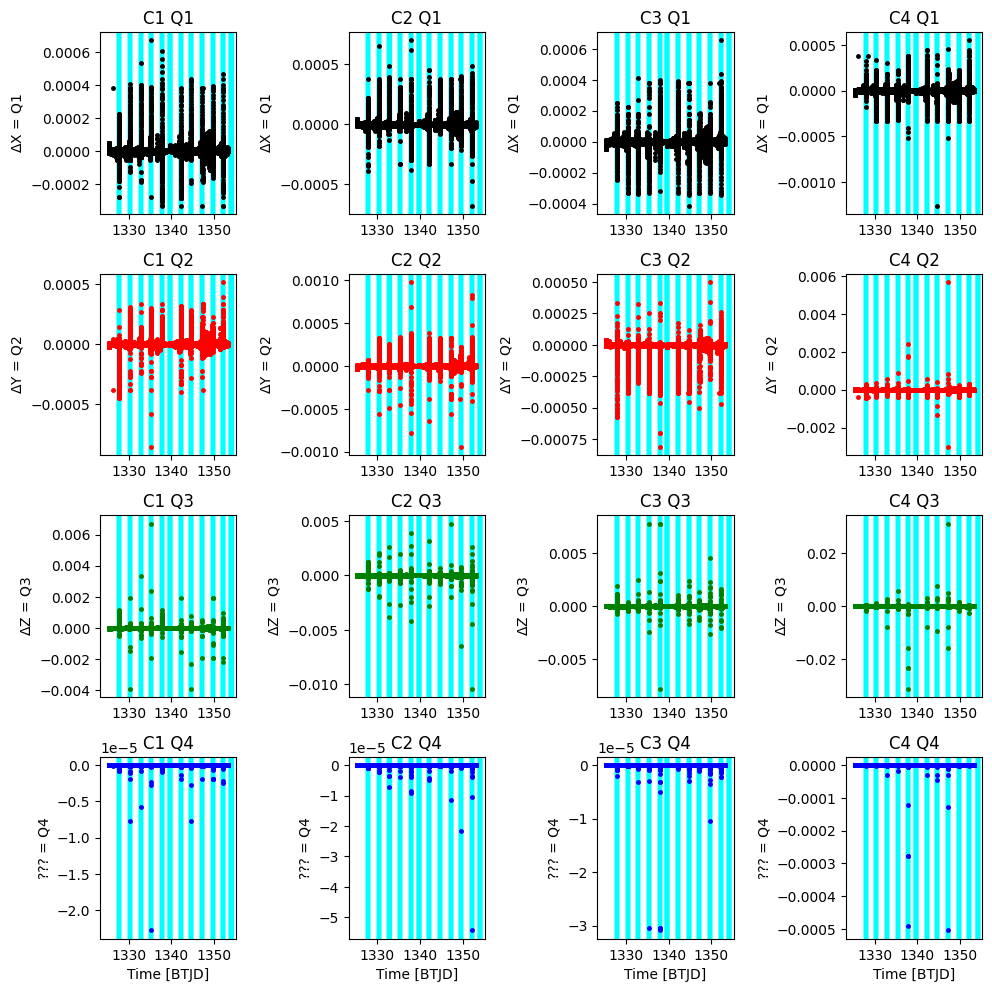

In [5]:
set_up_quaternion_directory_and_plots(pipelinepath=savepath, maxSectorNumber=1, 
                                      overwrite_plots=True,
                                      show_good_data=False,Nstd=None)

# This is the same plot but with basic sigma clipping of "high jitter" in the quaternion data. The "good" data is shown as grey points.

/Users/daxfeliz/Desktop/TESS/00_Current_Pipeline/test_new_features/step_3_removing_bad_data/quaternion_data/Sector_1_quaternion_data.fits exists! Loading...


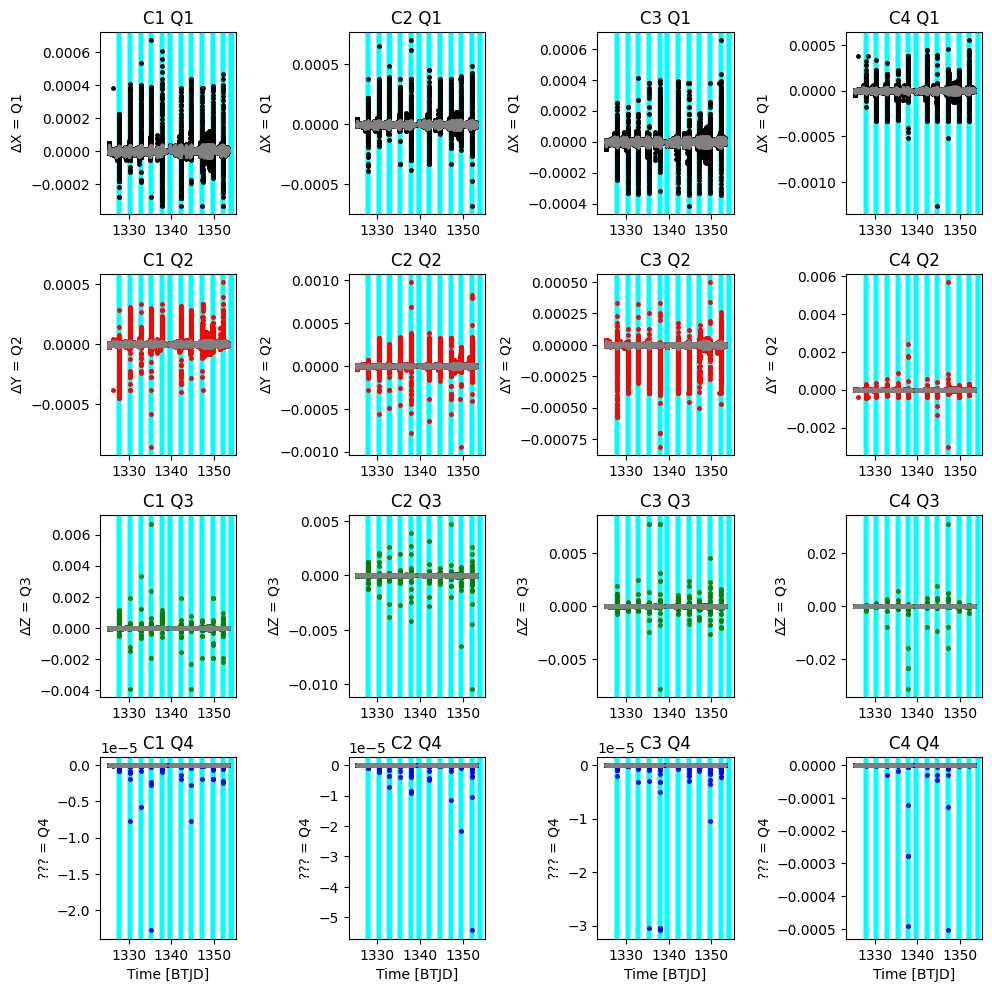

In [6]:
set_up_quaternion_directory_and_plots(pipelinepath=savepath, maxSectorNumber=1, 
                                      overwrite_plots=True,
                                      show_good_data=True,Nstd=5)

# CHALLENGE: I want to identify when the TESS telescope is experiencing high jitter in its quaternion data. With those high jitter timestamps, I then want to take TESS photometry (brightness (flux) over time)  and remove any timestamps from the TESS data that correspond with the high jitter timestamps from the quaternion data.



# Question 1: What does TESS photometry look like?

In [7]:
# target stars that have full TESS coverage across prime mission (S1-S26)
Sstar_TIC = 38759628  # has S1 -  S13
Nstar_TIC = 356735146 # has S14 - S26



# function to collect data from primary TESS mission
def extract_TESS_hdu(starname,author,save_directory,
                     cadence=None,mission=None,
                     quarter_number=None,debug=False,download=True,bitmask='hardest'):
    '''
    This function is used to extract single sector TESS light curves
    . Currently, 
    this function will only grab the first set of TESS observations
    from the 
    observation tables (search_result object).
    
    Inputs
    ------------------------------------------------------
        starname: Name of the star. Ex: 'TIC 12345678',
        'Proxima Centauri'. Object type: string, str
        author: 'Source of the TESS data. Ex: SPOC,
        TESS-SPOC, QLP'. Object type: string, str 
        nsigma: The number of standard deviations above and below 
        the median of our light curves to remove data from. type: float    
        save_directory: location on computer where figures are saved
        mask_threshold: Input value for aperture selection. 
        type: float or NoneType.
    
    Outputs
    ------------------------------------------------------
        outlier_removed_normalized_bkg_subtracted_lc: a lightkurve object containing
        extracted TESS photometry that is background subtracted, outlier removed and
        then normalized.
    '''
    #Step 0: import libraries we need
    import lightkurve as lk
    from lightkurve.search import _search_products
    from lightkurve.search import SearchError
    import matplotlib.pyplot as plt
    
    # Step 1: Search for TESS images (Target Pixel Files, or tpf)    
#     search_result = lk.search_targetpixelfile(starname,author=author)
#     if len(search_result)==0:
    if mission is None:
        mission='TESS'
    if mission=='TESS':
        if cadence is None:
            cadence='short'                
        if (cadence=='long') or (cadence=='30 minute') or (cadence=='10 minute'):
            ffi_or_tpf='FFI'
            if cadence=='30 minute':
                cadence_exp = 30*60
            if cadence=='10 minute':
                cadence_exp = 10*60 
            if cadence=='long':
                cadence_exp = cadence
        if (cadence=='short') or (cadence=='2 minute') or (cadence=='20 second') or (cadence=='fast'):
            ffi_or_tpf='Target Pixel'
            if cadence=='2 minute':
                cadence_exp = 2*60   
            if cadence=='20 second':
                cadence_exp = 20
            if cadence=='short':
                cadence_exp = cadence
                
        search_string=_search_products(starname, radius=21/3600,\
                                       filetype=ffi_or_tpf, \
                                       cadence=cadence_exp,\
                                       mission='TESS',sector=quarter_number)
        if debug==True:
            print(search_string)
        try:
            search_string=_search_products(starname, radius=21/3600,\
                                           filetype=ffi_or_tpf, \
                                           cadence=cadence_exp,\
                                           mission=mission,sector=quarter_number)
            # filter search result by cadence input argument
            if (cadence=='30 minute') or (cadence=='long'):
                mask = np.where((search_string.exptime.value>600) & (search_string.exptime.value<=1800) )[0]
                search_string_filtered = search_string[mask]
            if (cadence=='10 minute'):
                mask = np.where((search_string.exptime.value>120) & (search_string.exptime.value<=600) )[0]
                search_string_filtered = search_string[mask]
            if (cadence=='2 minute') or (cadence=='short'):
                mask = np.where((search_string.exptime.value>20) & (search_string.exptime.value<=120) )[0]
                search_string_filtered = search_string[mask]
            if (cadence=='20 second') or (cadence=='fast'):
                mask = np.where((search_string.exptime.value>0) & (search_string.exptime.value<=20) )[0]
                search_string_filtered = search_string[mask]            
            #make sure there are no duplicate quarters/sectors
            u, indices = np.unique(search_string_filtered.mission, return_index=True)
            search_result = search_string_filtered[indices]                
            if debug==True:
                print('')    
                print(search_result)

        except SearchError as e:
            print('No ',cadence,' cadence ',mission,' data for ',starname,' in Sector ',quarter_number,'!')
            print('nope none')
            print(e)                
                #
    # recall, MAST has a weird change in their observations table
    # -dataURL ---> dataURI
    # to make sure it's included, let's use a try and except technique    
    print('sr len check',len(search_result[0]))
    if download==True:
        try:
            try:
                tpf = search_result[0].download(quality_bitmask=bitmask,download_dir=save_directory) 
        #         tpf = search_result[0].download(download_dir=save_directory)         
                #will download only first observation [0]
            except KeyError:
                search_result.table['dataURL']  = search_result.table['dataURI']
                tpf = search_result[0].download(quality_bitmask=bitmask,download_dir=save_directory)
        #         tpf = search_result[0].download(download_dir=save_directory)        
        except IndexError as e:
            print(e)
            search_string=_search_products(starname, radius=21/3600, mission='TESS')
            if debug==True:
                print(search_string)
            if Sector<10:
                mask2=np.where(search_string.mission== 'TESS Sector 0'+str(Sector))
            else:
                mask2=np.where(search_string.mission== 'TESS Sector '+str(Sector))
            search_string=search_string[mask2]  
            # filter search result by cadence input argument
            if (cadence=='30 minute') or (cadence=='long'):
                mask = np.where((search_string.exptime.value>600) & (search_string.exptime.value<=1800) )[0]
                search_string_filtered = search_string[mask]
            if (cadence=='10 minute'):
                mask = np.where((search_string.exptime.value>120) & (search_string.exptime.value<=600) )[0]
                search_string_filtered = search_string[mask]
            if (cadence=='2 minute') or (cadence=='short'):
                mask = np.where((search_string.exptime.value>20) & (search_string.exptime.value<=120) )[0]
                search_string_filtered = search_string[mask]
            if (cadence=='20 second') or (cadence=='fast'):
                mask = np.where((search_string.exptime.value>0) & (search_string.exptime.value<=20) )[0]
                search_string_filtered = search_string[mask]            
            #make sure there are no duplicate quarters/sectors
            u, indices = np.unique(search_string_filtered.mission, return_index=True)
            search_result = search_string_filtered[indices]
            if debug==True:
                print(search_string)        
                print('')
                print('attempt #2')
                print(search_result)
                print('')
            try:
                tpf = search_result[0].download(quality_bitmask='hardest',download_dir=save_directory) 
        #         tpf = search_result[0].download(download_dir=save_directory)         
                #will download only first observation [0]
            except KeyError:
                search_result.table['dataURL']  = search_result.table['dataURI']
                tpf = search_result[0].download(quality_bitmask='hardest',download_dir=save_directory)

        print('target on Camera',tpf.camera,'CCD',tpf.ccd)

        return tpf
    else:
        return None
    
def needed_info_from_hdu(hdu,bad_data_only=False):
    time = np.array(hdu[1].data['TIME'],dtype=np.float64)
    timecorr= np.array(hdu[1].data['TIMECORR'],dtype=np.float64)
    print('time',time.dtype.byteorder)
    print('timecorr',timecorr.dtype.byteorder)

    quality_flag_pd,mask = interpret_quality_flags(hdu,bad_data_only)
    quality_vals=np.array(quality_flag_pd['Value'],dtype=np.int32)
    quality_flags=np.array(quality_flag_pd['Note'])

    if mask is not None:
        time = time[mask]
        timecorr=timecorr[mask]
    light_arrival_time = time - timecorr
    print('light_arrival_time',light_arrival_time.dtype.byteorder)
    import sys
    endian='='
#     output= pd.DataFrame({'time':time.byteswap().newbyteorder(endian),
#                           'timecorr':timecorr.byteswap().newbyteorder(endian),
#                           'light_arrival_time':light_arrival_time.byteswap().newbyteorder(endian),
#                           'quality_value':quality_vals.byteswap().newbyteorder(endian),
#                           'quality_flag':quality_flags.byteswap().newbyteorder(endian)
#                          })
    print(time[0:10],'\n',time.newbyteorder(endian)[0:10])
    
    
    # drop NaNs and redo byteorder to native endianess
    nanmask=np.where(np.isnan(time)==False)[0]
    time=time[nanmask]
    timecorr=timecorr[nanmask]
    light_arrival_time=light_arrival_time[nanmask]
    quality_flags=quality_flags[nanmask]
    quality_vals=quality_vals[nanmask]
    
    output= pd.DataFrame({'time':time.newbyteorder(endian),
                          'timecorr':timecorr.newbyteorder(endian),
                          'light_arrival_time':light_arrival_time.newbyteorder(endian),
                          'quality_value':quality_vals.newbyteorder(endian),
                          'quality_flag':quality_flags.newbyteorder(endian)
                         })
    return output    
def interpret_quality_flags(hdu,bad_data_only):
    if bad_data_only==True:
        mask = hdu[1].data['QUALITY']!=0
        flag_vals = np.array(hdu[1].data['QUALITY'][mask])
    else:
        mask = None        
        flag_vals = np.array(hdu[1].data['QUALITY'])
    flag_dict={'Good Data':0,
               'Attitude Tweak':2**0,
               'Safe Mode':2**1,
               'Spacecraft is in Coarse Point':2**2,
               'Spacecraft is in Earth Point':2**3,
               'Argabrightening event':2**4,
               'Reaction Wheel desaturation Event':2**5,
               'Cosmic Ray in Optimal Aperture pixel':2**6,
               'Manual Exclude. The cadence was excluded because of an anomaly':2**7,
               'Discontinuity corrected between this cadence and the following one.':2**8,
               'Impulsive outlier removed before cotrending.':2**9,
               'Cosmic ray detected on collateral pixel row or column':2**10,
               'Straylight from Earth or Moon in camera FOV.':2**11}
    flag_dict_pd = pd.DataFrame({'Note':list(flag_dict.keys()),'Value':list(flag_dict.values())})


    flag_note=[]
    for f in flag_vals:

        match = flag_dict_pd.loc[flag_dict_pd['Value']==f]['Note']#.item()
        if len(match)<1:
            flag_note = np.append(flag_note, 'Unknown Bit Value '+str(f))
        else:
            flag_note = np.append(flag_note, match)
    qual_flags_pd = pd.DataFrame({'Note':flag_note,'Value':flag_vals})
    # print(len(qual_flags_pd))
    return qual_flags_pd,mask
def primary_mission_timestamps_and_quality_flags(Sstar_TIC,Nstar_TIC,
                                                 cadence='2 minute',
                                                 bad_data_only=False):
    all_times = list()
    if cadence=='30 minute' or cadence=='long':
        author='TESS'
    if cadence=='10 minute':
        author='TESS-SPOC'  
    if cadence=='2 minute' or cadence=='short':
        author='SPOC'         
    for s in range(26):
        Sector=s+1
        if Sector<14:
            target=Sstar_TIC
        if Sector>=14:
            target=Nstar_TIC
        if Sector==14:
            print(' ')
            print('=================')
            print(' ')            
            print('South COMPLETE')
            print('=================')
            print(' ')
        if Sector==26:
            print(' ')
            print('=================')
            print(' ')            
            print('North COMPLETE')
            print('=================')
            print(' ')
        print('S',Sector,'TIC',target)
        tpf = extract_TESS_hdu('TIC '+str(target),
                               author,save_directory=os.getcwd()+'/',
                               cadence=cadence,mission=None,
                               quarter_number=Sector)
        hdu = tpf.hdu
        time_info = needed_info_from_hdu(hdu,bad_data_only)
        all_times.append(time_info)
    all_times = pd.concat(all_times)
    
    
    #combine time DF with tpf
    
    #remove NaN timestamps
    all_times = all_times[all_times['time'].notna()].reset_index(drop=True)
    
    return all_times



if os.path.isfile('all_time_stamps_S1-S26_30min.csv')==True:
    all_t_30min_S1_S26=pd.read_csv('all_time_stamps_S1-S26_30_min.csv')
else:    
    all_t_30min_S1_S26=primary_mission_timestamps_and_quality_flags(Sstar_TIC,Nstar_TIC,
                                                                   cadence='30 minute')



In [8]:
if os.path.isfile('all_time_stamps_S1-S26_2min.csv')==True:
    all_t_2min_S1_S26=pd.read_csv('all_time_stamps_S1-S26_2_min.csv')
else:
    all_t_2min_S1_S26=primary_mission_timestamps_and_quality_flags(Sstar_TIC,Nstar_TIC,
                                                               cadence='2 minute')

In [9]:
# these take a while to run, saving results
all_t_30min_S1_S26.to_csv('all_time_stamps_S1-S26_30_min.csv')
all_t_2min_S1_S26.to_csv('all_time_stamps_S1-S26_2_min.csv')

# Question 2: What is the sampling rate of the quaternion data? How does that compare with TESS data?

In [10]:
import astropy.units as u

TESS_cad_30min = (np.nanmedian(np.diff(all_t_30min_S1_S26['time']))*u.day).to(u.minute)
TESS_cad_2min = (np.nanmedian(np.diff(all_t_2min_S1_S26['time']))*u.day).to(u.minute)

# for example, just the 1st sector
SectorNumber=1
Camera=1
quaternion_data = make_qdata_df(qdata = get_qdata(SectorNumber=SectorNumber, 
                                                  savepath=savepath, overwrite=overwrite),
                                Camera=Camera)

qdata_cad_2sec = (np.nanmedian(np.diff(quaternion_data['TIME']))*u.day).to(u.second)


print('TESS data cadences: ',TESS_cad_30min,'& ',TESS_cad_2min)
print('quaternion data cadences:',qdata_cad_2sec)

/Users/daxfeliz/Desktop/TESS/00_Current_Pipeline/test_new_features/step_3_removing_bad_data/quaternion_data/Sector_1_quaternion_data.fits exists! Loading...
TESS data cadences:  29.99972701243678 min &  1.9999996912156348 min
quaternion data cadences: 1.9999992691737134 s


In [11]:
quaternion_data.head(1)

,TIME,C1_FOM,C1_NUM_GSUSED,C1_NUM_MSTOT,C1_Q1,C1_Q2,C1_Q3,C1_Q4,C1_Q1_SC,C1_Q2_SC,C1_Q3_SC,C1_Q4_SC
0,1325.292823,236.0,199.0,200.0,0.000047,-0.000027,-0.000036,1.0,0.000043,0.000047,-0.000013,1.0





# Question 3: What are the time coordinates of the two data sets?

# I believe the quaternion data is in "light arrival time", meaning when light touches the detector of the camera on the satellite. 

# the TESS data has a relativistic correction (called 'TIMECORR') that is applied to the timestamps (called Barycentric TESS Julian Date). To work back what is the light arrival time, we simply subtract TIMECORR from the TESS timestamps

# Let's compare timestamps

In [12]:
def compare_timestamps(x,ylevel,label,ax,color,ms=None,zorder=1):
    if type(ms)==type(None):
        ax.plot(x,[ylevel] * len(x),
                 linestyle='None',color=color,marker='.',
                 markersize=10, label=label,zorder=zorder)
    else:
        ax.plot(x,[ylevel] * len(x),
                 linestyle='None',color=color,marker='.',
                 markersize=ms, label=label,zorder=zorder)

In [13]:
# limit TESS data to just Sector 1

s1_times_2min= all_t_2min_S1_S26.loc[(all_t_2min_S1_S26['light_arrival_time']>=np.min(quaternion_data['TIME'])) &
                                     (all_t_2min_S1_S26['light_arrival_time']<=np.max(quaternion_data['TIME']))
                                    ].reset_index(drop=True)

s1_times_30min= all_t_30min_S1_S26.loc[(all_t_30min_S1_S26['light_arrival_time']>=np.min(quaternion_data['TIME'])) & 
                                       (all_t_30min_S1_S26['light_arrival_time']<=np.max(quaternion_data['TIME']))
                                      ].reset_index(drop=True)





# for plotting
yoff = 0.05
# md1=1327.8375; xspan=4*(30*u.minute).to(u.day).value
md1=1348 ; xspan=1.5 # a known region of high jitter data in S1


In [14]:
def rescale(y):
    y_normalized = (y - np.nanmin(y)) / (np.nanmax(y) - np.nanmin(y))
    y_normalized = y_normalized - np.nanmedian(y_normalized)
    return y_normalized

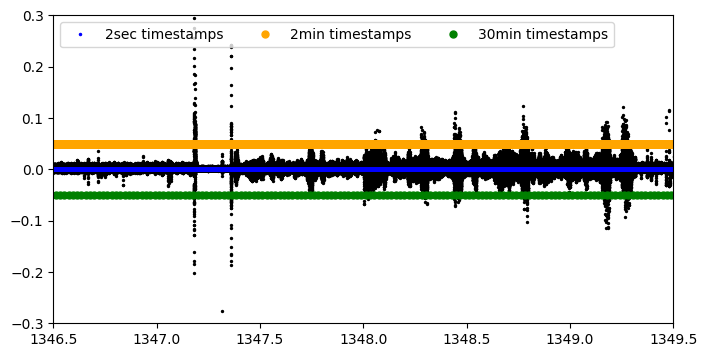

In [15]:
# compare with region of known high jitter

fig=plt.figure(figsize=((8,4)))
ax1=fig.add_subplot(111)




ax1.scatter(quaternion_data['TIME'],rescale(quaternion_data['C'+str(Camera)+'_Q1']),color='black',s=2)
ax1.scatter(quaternion_data['TIME'],rescale(quaternion_data['C'+str(Camera)+'_Q2']),color='black',s=2)
ax1.scatter(quaternion_data['TIME'],rescale(quaternion_data['C'+str(Camera)+'_Q3']),color='black',s=2)



compare_timestamps(x=quaternion_data['TIME'],ylevel=0,label='2sec timestamps',
                   ax=ax1,color='blue',ms=3)
compare_timestamps(x=s1_times_2min['light_arrival_time'],ylevel=yoff,label='2min timestamps',
                   ax=ax1,color='orange')


compare_timestamps(x=s1_times_30min['light_arrival_time'],ylevel=-yoff,label='30min timestamps',
                   ax=ax1,color='green')



ax1.set_ylim(-0.3,0.3)


ax1.set_xlim(md1-xspan,md1+xspan)

# ax.legend(loc=2,bbox_to_anchor=[1,1.01])
ax1.legend(loc='upper left',ncol=3)
# ax2.legend(loc='upper left',ncol=2)#,bbox_to_anchor=[1,1.01])
plt.show()


# compare with a randomly selected TESS data point

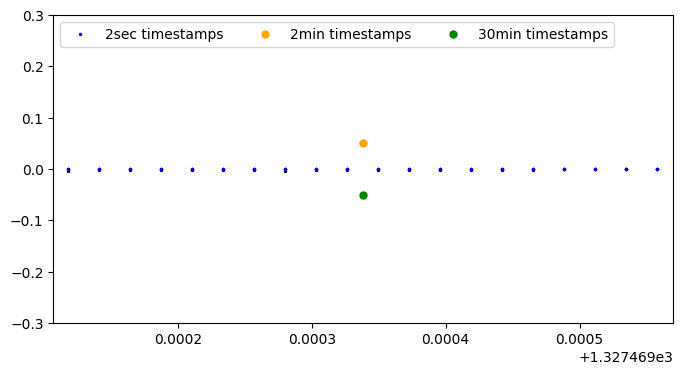

In [16]:


def random_row(df, n):
     return df.sample(n=n)

random_t30 = random_row(s1_times_30min,1)['light_arrival_time'].item()


fig=plt.figure(figsize=((8,4)))
ax1=fig.add_subplot(111)




ax1.scatter(quaternion_data['TIME'],rescale(quaternion_data['C'+str(Camera)+'_Q1']),color='black',s=2)
ax1.scatter(quaternion_data['TIME'],rescale(quaternion_data['C'+str(Camera)+'_Q2']),color='black',s=2)
ax1.scatter(quaternion_data['TIME'],rescale(quaternion_data['C'+str(Camera)+'_Q3']),color='black',s=2)



compare_timestamps(x=quaternion_data['TIME'],ylevel=0,label='2sec timestamps',
                   ax=ax1,color='blue',ms=3)
compare_timestamps(x=s1_times_2min['light_arrival_time'],ylevel=yoff,label='2min timestamps',
                   ax=ax1,color='orange')


compare_timestamps(x=s1_times_30min['light_arrival_time'],ylevel=-yoff,label='30min timestamps',
                   ax=ax1,color='green')



ax1.set_ylim(-0.3,0.3)


ax1.set_xlim(random_t30 - 10*qdata_cad_2sec.to(u.day).value, 
             random_t30 + 10*qdata_cad_2sec.to(u.day).value)

# ax.legend(loc=2,bbox_to_anchor=[1,1.01])
ax1.legend(loc='upper left',ncol=3)
# ax2.legend(loc='upper left',ncol=2)#,bbox_to_anchor=[1,1.01])
plt.show()


In [17]:
# IDEAs:
# check shifting bins to left/right
# check cross correlation of two time signals (correlation vs lag time)
# ## if there are peaks near 30 min (example) than there should be a sharp drop off,
# ## otherwise there might be another feature that's not so simple

# IDEA 1: Bin qdata to TESS cadences

In [18]:
def generate_q_mask_overall_ALT2(quaternion_data, Camera, Nstd):
    
    qtimeCN,qquat_CNQ1=make_qdata_arr(quaternion_data,Camera=Camera,Qnum=1,return_time=True)
    qquat_CNQ2 =       make_qdata_arr(quaternion_data,Camera=Camera,Qnum=2,return_time=False)
    qquat_CNQ3 =       make_qdata_arr(quaternion_data,Camera=Camera,Qnum=3,return_time=False)
    
    #sort by time
    qquat_CNQ1 = qquat_CNQ1[np.argsort(qtimeCN)]
    qquat_CNQ2 = qquat_CNQ2[np.argsort(qtimeCN)]
    qquat_CNQ3 = qquat_CNQ3[np.argsort(qtimeCN)]
    
    # remove median value
    qquat_CNQ1 -= np.nanmedian(qquat_CNQ1)
    qquat_CNQ2 -= np.nanmedian(qquat_CNQ2)
    qquat_CNQ3 -= np.nanmedian(qquat_CNQ3)
    
    # Generate mask based on those above Nstd
    q_mask1 = np.abs(qquat_CNQ1) <= Nstd*np.nanstd(qquat_CNQ1)
    q_mask2 = np.abs(qquat_CNQ2) <= Nstd*np.nanstd(qquat_CNQ2)
    q_mask3 = np.abs(qquat_CNQ3) <= Nstd*np.nanstd(qquat_CNQ3)
    # don't use scalar in mask, only vector components
    q_mask_overall = (q_mask1 == True) & (q_mask2 == True) & (q_mask3 == True) #& (q_mask4 == True) 
    return q_mask_overall

def bin_it(quaternion_data, tess_timestamps, Nstd, bin_shift='center'):
    import numpy as np
    import pandas as pd
    import astropy.units as u
    
    #check timestamps are sorted
    quaternion_data = quaternion_data.sort_values(by='TIME').reset_index(drop=True)   
    tess_timestamps = np.sort(tess_timestamps)
    
    # Calculate cadences
    qcad = np.nanmedian(np.diff(quaternion_data['TIME'].to_numpy()))
    tesscad = np.nanmedian(np.diff(tess_timestamps))    
    
    # check that qdata is within tess timestamps
    quaternion_data = quaternion_data.loc[(quaternion_data['TIME']>=np.nanmin(tess_timestamps)-tesscad)&
                                         (quaternion_data['TIME']<=np.nanmax(tess_timestamps)+tesscad)]

    Camera = int(quaternion_data.columns[1].split('_')[0][1]) #getting it from string
    # calculate qdata mask
    if type(Nstd)==type(None):
        q_mask_overall =generate_q_mask_overall_ALT2(quaternion_data,Camera,Nstd=3)
    else:
        q_mask_overall =generate_q_mask_overall_ALT2(quaternion_data,Camera,Nstd=Nstd)
    print(q_mask_overall[0:10])
    
    quaternion_data['qmask']=q_mask_overall.astype(int)
#     print(quaternion_data.loc[quaternion_data['qmask']!=1][['TIME','qmask']].iloc[0:10])
    


    # Set bin shift
    if bin_shift == 'center':
        bin_shift_sec = 0
    elif bin_shift == 'left':
        bin_shift_sec = 0-(qcad* u.day).to(u.second).value #/ 2
    elif bin_shift == 'right':
        bin_shift_sec = 0-(qcad* u.day).to(u.second).value  #/ 2

    if (type(bin_shift) != str) & (type(bin_shift) != type(None)):
        bin_shift_sec = (bin_shift * u.day).to(u.second).value

    # Convert bin_shift_sec to days
    bin_shift_days = (bin_shift_sec * u.second).to(u.day).value

    # Apply bin_shift_days to tess_times
    tess_times_shifted = tess_timestamps #+ bin_shift_days

    # Compute midpoints between consecutive shifted TESS times
    midpoints = (tess_times_shifted[:-1] + tess_times_shifted[1:]) / 2

    # Define bin edges
    first_edge = tess_times_shifted[0] - (tess_times_shifted[1] - tess_times_shifted[0]) / 2
    last_edge = tess_times_shifted[-1] + (tess_times_shifted[-1] - tess_times_shifted[-2]) / 2
    
    #
#     bin_edges = np.concatenate(([first_edge], midpoints, [last_edge])) #+ bin_shift_days
#     bin_edges -=  bin_shift_days
    
    
    # Define bin edges centered on TESS timestamps
    delta_t = tesscad
    bin_edges = tess_timestamps - delta_t #/ 2  # Left edges of bins
    bin_edges = np.append(bin_edges, tess_timestamps[-1] + delta_t)# / 2)  # Add the rightmost edge

    # Shift the bin edges directly
    bin_edges_shifted = bin_edges + bin_shift_days

    # Assign each quaternion time to a bin using the shifted bin edges
    quat_times = quaternion_data['TIME'].to_numpy()
    bin_indices = np.digitize(quat_times, bins=bin_edges_shifted) - 1  # Adjust indices to be 0-based

    # Filter out invalid bin indices
    valid_mask = (bin_indices >= 0) & (bin_indices < len(tess_timestamps))
    bin_indices = bin_indices[valid_mask]
    quat_times = quat_times[valid_mask]

    # Extract all columns except 'TIME'
    data_columns = [col for col in quaternion_data.columns if col != 'TIME']
    data_arrays = {col: quaternion_data[col].to_numpy()[valid_mask] for col in data_columns}

    # Create DataFrame with quaternion data and bin indices
    df_quat = pd.DataFrame({
        'TIME': quat_times,
        'bin_index': bin_indices,
        **data_arrays
    })

    # Group by bin_index
    grouped_quat = df_quat.groupby('bin_index')

    # Define aggregation functions
    aggregation_functions = {}
    for col in data_columns:
        if col != 'qmask':
            aggregation_functions[col] = 'mean'
        else:
            aggregation_functions[col] = 'all'  # Use 'all' for boolean 'qmask'

    # Aggregate data within each bin
    aggregated_quat = grouped_quat.agg(aggregation_functions)

    # Create DataFrame for TESS data
    df_tess = pd.DataFrame({
        'TIME': tess_timestamps
    })

    # Initialize columns in df_tess
    for col in aggregated_quat.columns:
        if col != 'TIME':
            #df_tess[col + '_mean'] = np.nan
            df_tess[col] = np.nan# + '_mean'] = np.nan

    # Map aggregated data to df_tess using bin_index
    for col in aggregated_quat.columns:
        if col != 'TIME':
#             df_tess.loc[aggregated_quat.index, col + '_mean'] = aggregated_quat[col].values
            df_tess.loc[aggregated_quat.index, col] = aggregated_quat[col].values

    # Return the DataFrame with aggregated data
#     df_tess['qmask'] = df_tess['qmask'].apply(lambda x: int(round(x)))
    df_tess['qmask'] = df_tess['qmask'].apply(lambda x: round(x) if pd.notnull(x) else x)

    return df_tess



In [19]:
Nstd = 3

In [20]:
qbin_30_C = bin_it(quaternion_data, 
                 tess_timestamps=s1_times_30min['light_arrival_time'].to_numpy(), 
                 bin_shift='center',Nstd=Nstd)
#NOTE: choosing different bin_shifts doesn't seem to matter...
qbin_30_C.loc[qbin_30_C['qmask']==0].head(10)

[ True  True  True  True  True  True  True  True  True  True]


/var/folders/d6/bx0psnrd363g4sx9mcbdf5hm0000gn/T/ipykernel_98903/4182123050.py:141: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ True  True  True ... False  True  True]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_tess.loc[aggregated_quat.index, col] = aggregated_quat[col].values


,TIME,C1_FOM,C1_NUM_GSUSED,C1_NUM_MSTOT,C1_Q1,C1_Q2,C1_Q3,C1_Q4,C1_Q1_SC,C1_Q2_SC,C1_Q3_SC,C1_Q4_SC,qmask
31,1325.969339,251.413333,199.962222,200.0,-0.000002,-0.000001,-8.017027e-07,1.0,0.000002,-0.000002,1.682079e-07,1.0,0
50,1326.365172,251.431111,199.912222,200.0,-0.000002,-0.000002,-9.817225e-07,1.0,0.000002,-0.000002,1.169576e-07,1.0,0
66,1326.698506,251.360000,199.958889,200.0,-0.000002,-0.000001,-1.069609e-06,1.0,0.000002,-0.000002,-1.404090e-07,1.0,0
67,1326.719339,251.431111,199.963333,200.0,-0.000002,-0.000001,-1.047638e-06,1.0,0.000002,-0.000002,-1.108102e-07,1.0,0
87,1327.136005,251.555556,199.972222,200.0,-0.000002,-0.000001,-1.213855e-06,1.0,0.000002,-0.000002,-2.822716e-07,1.0,0
88,1327.156839,251.431111,199.964444,200.0,-0.000002,-0.000001,-1.211265e-06,1.0,0.000002,-0.000002,-2.751119e-07,1.0,0
89,1327.177672,251.342222,199.955556,200.0,-0.000002,-0.000001,-1.151609e-06,1.0,0.000002,-0.000002,-2.406030e-07,1.0,0
118,1327.781838,251.502222,199.968889,200.0,-0.000002,-0.000001,-1.332892e-06,1.0,0.000002,-0.000002,-4.040370e-07,1.0,0
121,1327.844338,245.254727,195.075640,200.0,-0.000006,-0.000019,3.272834e-05,1.0,-0.000004,-0.000006,3.772605e-05,1.0,0
152,1328.490171,251.377778,199.961111,200.0,-0.000002,-0.000001,-1.667640e-06,1.0,0.000002,-0.000002,-7.225991e-07,1.0,0


In [21]:
qbin_2_C = bin_it(quaternion_data, 
                 tess_timestamps=s1_times_2min['light_arrival_time'].to_numpy(), 
                 bin_shift='center',Nstd=Nstd)

qbin_2_C.loc[qbin_2_C['qmask']==0].head(10)

[False False False False False False False False False False]


/var/folders/d6/bx0psnrd363g4sx9mcbdf5hm0000gn/T/ipykernel_98903/4182123050.py:141: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[False  True  True ...  True  True  True]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_tess.loc[aggregated_quat.index, col] = aggregated_quat[col].values


,TIME,C1_FOM,C1_NUM_GSUSED,C1_NUM_MSTOT,C1_Q1,C1_Q2,C1_Q3,C1_Q4,C1_Q1_SC,C1_Q2_SC,C1_Q3_SC,C1_Q4_SC,qmask
0,1325.294339,239.200000,199.133333,200.0,0.000012,-1.065152e-05,-1.054381e-05,1.0,0.000015,0.000012,-2.269313e-06,1.0,0
481,1325.962395,250.933333,199.933333,200.0,-0.000005,-2.194928e-06,-1.237309e-06,1.0,0.000003,-0.000005,2.891424e-07,1.0,0
759,1326.348506,250.133333,199.133333,200.0,0.000006,-5.948728e-06,-1.018022e-06,1.0,0.000005,0.000006,2.672977e-06,1.0,0
1003,1326.687394,252.000000,200.000000,200.0,-0.000003,-1.212671e-06,-8.759123e-07,1.0,0.000001,-0.000003,4.162194e-09,1.0,0
1021,1326.712394,252.000000,200.000000,200.0,-0.000002,-1.446606e-06,-6.725394e-07,1.0,0.000002,-0.000002,3.061980e-07,1.0,0
1316,1327.122116,251.733333,199.983333,200.0,-0.000002,-9.232225e-07,-1.646932e-06,1.0,0.000002,-0.000002,-7.897391e-07,1.0,0
1317,1327.123505,251.466667,199.966667,200.0,-0.000002,-1.665820e-06,-5.783341e-07,1.0,0.000002,-0.000002,5.112622e-07,1.0,0
1326,1327.136005,251.466667,199.966667,200.0,-0.000002,-1.236275e-06,-1.124106e-06,1.0,0.000002,-0.000002,-1.827563e-07,1.0,0
1340,1327.155450,251.200000,199.950000,200.0,-0.000002,-1.483686e-06,-9.177932e-07,1.0,0.000002,-0.000002,1.295783e-07,1.0,0
1347,1327.165172,252.000000,200.000000,200.0,-0.000002,-1.383284e-06,-1.069210e-06,1.0,0.000002,-0.000002,-5.193532e-08,1.0,0


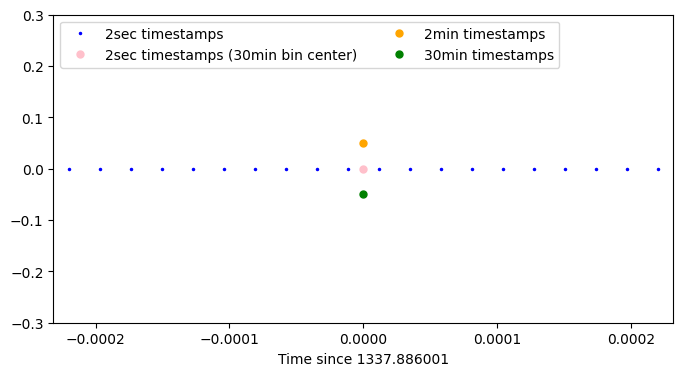

In [22]:


def random_row(df, n):
     return df.sample(n=n)

random_t30 = random_row(s1_times_30min,1)['light_arrival_time'].item()


fig=plt.figure(figsize=((8,4)))
ax1=fig.add_subplot(111)



compare_timestamps(x=quaternion_data['TIME']-random_t30,ylevel=0,label='2sec timestamps',
                   ax=ax1,color='blue',ms=3)
compare_timestamps(x=qbin_30_C['TIME']-random_t30,ylevel=0,label='2sec timestamps (30min bin center)',
                   ax=ax1,color='pink')


compare_timestamps(x=s1_times_2min['light_arrival_time']-random_t30,ylevel=yoff,label='2min timestamps',
                   ax=ax1,color='orange')


compare_timestamps(x=s1_times_30min['light_arrival_time']-random_t30,ylevel=-yoff,label='30min timestamps',
                   ax=ax1,color='green')



ax1.set_ylim(-0.3,0.3)

Ncadences = 10

ax1.set_xlim(0- Ncadences*qdata_cad_2sec.to(u.day).value,
             0 + Ncadences*qdata_cad_2sec.to(u.day).value)
ax1.set_xlabel('Time since '+str(np.round(random_t30,6)))
# ax.legend(loc=2,bbox_to_anchor=[1,1.01])
ax1.legend(loc='upper left',ncol=2)
# ax2.legend(loc='upper left',ncol=2)#,bbox_to_anchor=[1,1.01])
plt.show()


# let's test it on TESS LC?

In [23]:
Nstar_TIC = 356735146 #has S14-S26
Sstar_TIC = 38759628# has S1-S13
live_update=False

Sector=1
bad_data_only=False

getnewlc=True

if os.path.isfile('2_min_test_lc.csv')==True:
    import lightkurve as lk
    lc2 = pd.read_csv('2_min_test_lc.csv')
    lc2 = lk.LightCurve(time=lc2.time.to_numpy(),
                        flux=lc2.flux.to_numpy(),
                        flux_err=lc2.flux_err.to_numpy())    
else:    
    cadence='2 minute'

    if Sector<14:
        target=Sstar_TIC
    if Sector>=14:
        target=Nstar_TIC

    if cadence=='30 minute' or cadence=='long':
        author='TESS'
        maxgap=30/60/24
    if cadence=='10 minute':
        author='TESS-SPOC'  
        maxgap=30/60/24
    if cadence=='2 minute' or cadence=='short':
        author='SPOC'  
        maxgap=2/60/24
        
    tpf_2min = extract_TESS_hdu('TIC '+str(target),
                           author,save_directory=os.getcwd()+'/',
                           cadence=cadence,mission=None,
                           quarter_number=Sector,bitmask='none')
    # save results bc it can take a while
    lc2 =tpf_2min.to_lightcurve( aperture_mask =tpf_2min.create_threshold_mask(threshold=7.5, reference_pixel='center')).remove_nans()

    pd.DataFrame({'time':lc2.time.value,
                 'flux':lc2.flux.value,
                 'flux_err':lc2.flux_err.value}).to_csv('2_min_test_lc.csv')

if os.path.isfile('30_min_test_lc.csv')==True:
    import lightkurve as lk
    lc30 = pd.read_csv('30_min_test_lc.csv')
    lc30 = lk.LightCurve(time=lc30.time.to_numpy(),
                         flux=lc30.flux.to_numpy(),
                         flux_err=lc30.flux_err.to_numpy())
else:
    cadence='30 minute'

    if Sector<14:
        target=Sstar_TIC
    if Sector>=14:
        target=Nstar_TIC

    if cadence=='30 minute' or cadence=='long':
        author='TESS'
        maxgap=30/60/24
    if cadence=='10 minute':
        author='TESS-SPOC'  
        maxgap=30/60/24
    if cadence=='2 minute' or cadence=='short':
        author='SPOC'  
        maxgap=2/60/24

    tpf_30min = extract_TESS_hdu('TIC '+str(target),
                           author,save_directory=os.getcwd()+'/',
                           cadence=cadence,mission=None,
                           quarter_number=Sector,bitmask='none')
    lc30=tpf_30min.to_lightcurve(aperture_mask=tpf_30min.create_threshold_mask(threshold=7.5, reference_pixel='center')).remove_nans()
    # save results bc it can take a while

    pd.DataFrame({'time':lc30.time.value,
                 'flux':lc30.flux.value,
                 'flux_err':lc30.flux_err.value}).to_csv('30_min_test_lc.csv')

In [27]:
def process_tess_data(Sector, Sstar_TIC, Nstar_TIC, 
                      cadence, save_directory, output_type='lk'):
    """
    Processes TESS data for a given sector and cadence, and saves the light curve to a CSV file.

    Parameters:
        Sector (int): The TESS sector number.
        Sstar_TIC (int): TIC ID for sectors before 14.
        Nstar_TIC (int): TIC ID for sectors 14 and after.
        cadence (str): The cadence of the data ('2 minute', '10 minute', '30 minute', 'short', 'long').
        save_directory (str): Directory where the data will be saved.

    Returns:
        None
    """
    import os
    import pandas as pd

    # Determine the target based on the sector
    if Sector < 14:
        target = Sstar_TIC
    else:
        target = Nstar_TIC

    # Determine the author and maxgap based on the cadence
    if cadence in ['30 minute', 'long']:
        author = 'TESS'
        maxgap = 30 / 60 / 24  # Convert minutes to days
    elif cadence == '10 minute':
        author = 'TESS-SPOC'
        maxgap = 10 / 60 / 24
    elif cadence in ['2 minute', 'short']:
        author = 'SPOC'
        maxgap = 2 / 60 / 24
    else:
        raise ValueError("Invalid cadence value. Choose from '2 minute', '10 minute', '30 minute', 'short', or 'long'.")

    # Extract the TESS data
    tpf_2min = extract_TESS_hdu(
        'TIC ' + str(target),
        author=author,
        save_directory=save_directory,
        cadence=cadence,
        mission=None,
        quarter_number=Sector,
        bitmask='none'
    )

    # Process the data into a light curve
    lc2 = tpf_2min.to_lightcurve(
        aperture_mask=tpf_2min.create_threshold_mask(threshold=7.5, reference_pixel='center')
    ).remove_nans()

    # Save the light curve data to a CSV file
    lc_df = pd.DataFrame({
        'time': lc2.time.value,
        'flux': lc2.flux.value,
        'flux_err': lc2.flux_err.value
    })
    output_csv = os.path.join(save_directory, '2_min_test_lc.csv')
    lc_df.to_csv(output_csv, index=False)
    print(f"Light curve data saved to {output_csv}")
    if output_type=='lk':
        return lc2
    if output_type=='df':
        return lc_df

In [30]:
lc30=process_tess_data(Sector, Sstar_TIC, Nstar_TIC, 
                      cadence='30 minute', save_directory=os.getcwd()+'/',
                      output_type='lk')

lc2=process_tess_data(Sector, Sstar_TIC, Nstar_TIC, 
                      cadence='2 minute', save_directory=os.getcwd()+'/',
                      output_type='lk')

sr len check 1
target on Camera 4 CCD 1
Light curve data saved to /Users/daxfeliz/Desktop/TESS/00_Current_Pipeline/test_new_features/step_3_removing_bad_data/2_min_test_lc.csv
sr len check 1
target on Camera 4 CCD 1
Light curve data saved to /Users/daxfeliz/Desktop/TESS/00_Current_Pipeline/test_new_features/step_3_removing_bad_data/2_min_test_lc.csv


In [31]:
print((np.nanmedian(np.diff(lc30.time.value))*u.day).to(u.minute))
print((np.nanmedian(np.diff(lc2.time.value))*u.day).to(u.minute))

30.00031577728805 min
2.000030546441849 min


In [32]:
lc30.head(1)

time,flux,flux_err,centroid_col,centroid_row,cadenceno,quality
,electron / s,electron / s,pix,pix,,
Time,float32,float32,float64,float64,int64,int32
1325.323974336618,4159.9794921875,1.7724852561950684,571.4666215865041,1084.9999681617928,0,0


# Let's visualize the quality flags from TESS light curves with a discrete colorbar for unique quality flag values

In [89]:
def scatter_with_discrete_colorbar(x, y, z, xlabel='X-axis', ylabel='Y-axis', title='Scatter Plot with Discrete Colorbar', colorbar_title=None, cmap_name='tab10', edgecolor='k', s=100):
    """
    Creates a scatter plot of x vs y, with points colored according to discrete values of z.
    A colorbar is added to show the mapping from colors to unique z values.

    Parameters:
        x (array-like): x coordinates of the data points.
        y (array-like): y coordinates of the data points.
        z (array-like): Data corresponding to colors (categorical or numerical).
        xlabel (str): Label for the x-axis.
        ylabel (str): Label for the y-axis.
        title (str): Title of the plot.
        colorbar_title (str): Title for the colorbar. Default is None.
        cmap_name (str): Name of the colormap to use (default is 'tab10').
        edgecolor (str or None): Color of the marker edges.
        s (scalar or array-like): Size of the markers.

    Returns:
        fig, ax: The figure and axes objects of the plot.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.colors import ListedColormap, BoundaryNorm

    # Convert z to a NumPy array
    z = np.array(z)

    # Map unique values of z to integers
    unique_z = np.unique(z)
    z_to_int = {category: index for index, category in enumerate(unique_z)}
    int_z = np.array([z_to_int[val] for val in z])

    # Number of unique categories
    num_categories = len(unique_z)

    # Create a discrete colormap
    cmap_base = plt.get_cmap(cmap_name)
    if hasattr(cmap_base, 'colors') and len(cmap_base.colors) >= num_categories:
        colors = cmap_base.colors[:num_categories]
    else:
        colors = cmap_base(np.linspace(0, 1, num_categories))
    cmap = ListedColormap(colors)

    # Create a normalization object
    norm = BoundaryNorm(boundaries=np.arange(num_categories + 1) - 0.5, ncolors=num_categories)

    # Create the scatter plot
    fig, ax = plt.subplots(figsize=(8, 6))
    scatter = ax.scatter(x, y, c=int_z, cmap=cmap, norm=norm, 
                         edgecolor=edgecolor, s=s, linewidths=0.5)

    # Create a colorbar with ticks at integer positions
    cbar = plt.colorbar(scatter, ticks=np.arange(num_categories))
    cbar.ax.set_yticklabels(unique_z)  # Set labels for colorbar

    # Set colorbar title if provided
    if colorbar_title is not None:
        cbar.set_label(colorbar_title,rotation=270,labelpad=15)

    # Add labels and title
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

#     plt.grid(True)
#     plt.show()

    return fig, ax



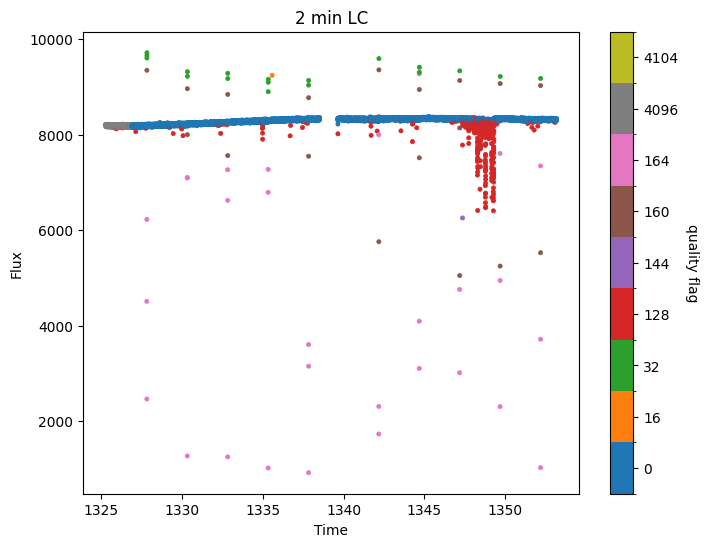

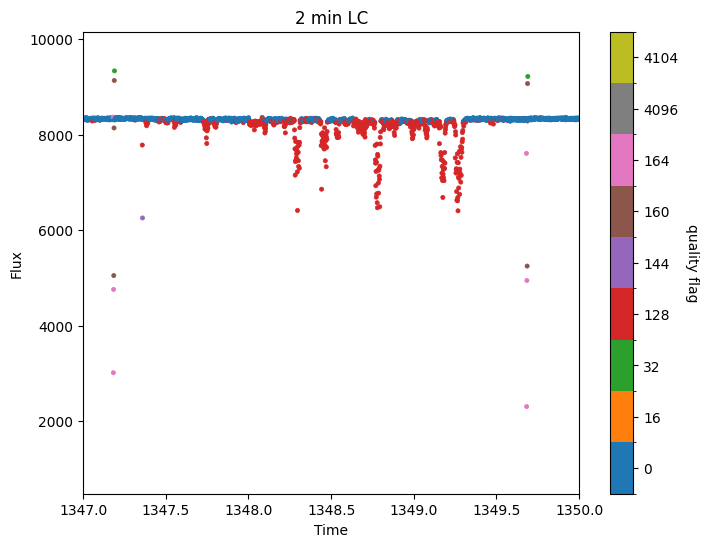

In [96]:
ms=3

fig, ax = scatter_with_discrete_colorbar(x=lc2.time.value, 
                                         y=lc2.flux.value, 
                                         z=lc2.quality.value, 
                                         xlabel='Time', ylabel='Flux', 
                                         title='2 min LC',
                                         cmap_name='tab10', edgecolor=None, 
                                         s=ms**2,colorbar_title='quality flag')
# ax.scatter(1348,8000,color='cyan',s=10**2,marker='o',zorder=1000)
plt.show()


fig, ax = scatter_with_discrete_colorbar(x=lc2.time.value, 
                                         y=lc2.flux.value, 
                                         z=lc2.quality.value, 
                                         xlabel='Time', ylabel='Flux', 
                                         title='2 min LC',
                                         cmap_name='tab10', edgecolor=None, 
                                         s=ms**2,colorbar_title='quality flag')
ax.set_xlim(1347,1350)
plt.show()

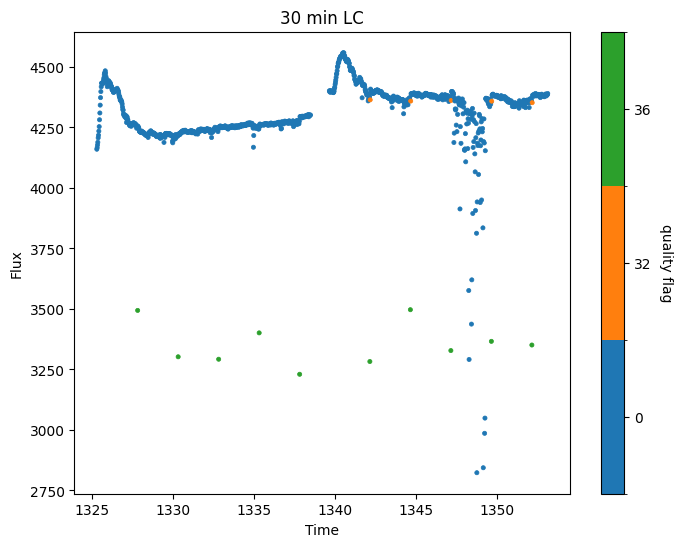

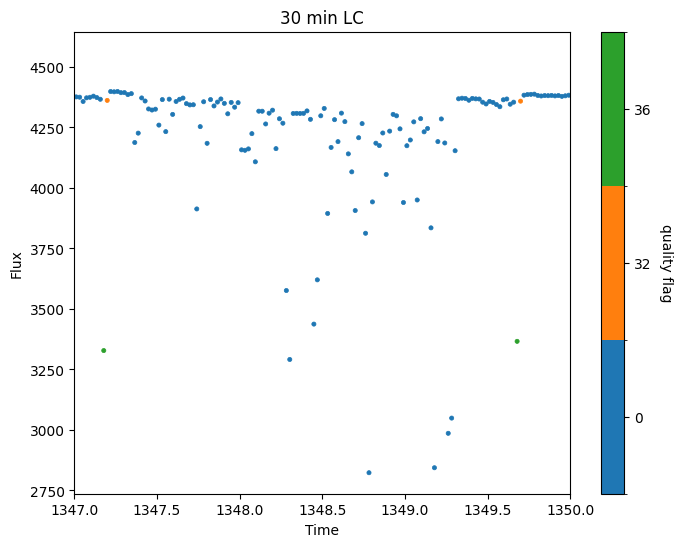

In [97]:
fig, ax = scatter_with_discrete_colorbar(x=lc30.time.value, 
                                         y=lc30.flux.value, 
                                         z=lc30.quality.value, 
                                         xlabel='Time', ylabel='Flux', 
                                         title='30 min LC',
                                         cmap_name='tab10', edgecolor=None, 
                                         s=ms**2,colorbar_title='quality flag')
# ax.scatter(1348,8000,color='cyan',s=10**2,marker='o',zorder=1000)
plt.show()


fig, ax = scatter_with_discrete_colorbar(x=lc30.time.value, 
                                         y=lc30.flux.value, 
                                         z=lc30.quality.value, 
                                         xlabel='Time', ylabel='Flux', 
                                         title='30 min LC',
                                         cmap_name='tab10', edgecolor=None, 
                                         s=ms**2,colorbar_title='quality flag')
ax.set_xlim(1347,1350)
plt.show()

# Now incorporate visual of matched bad quaternions into image:

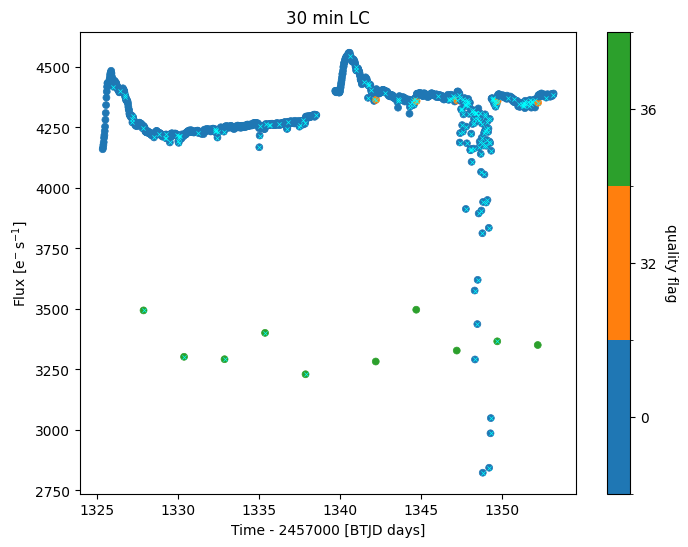

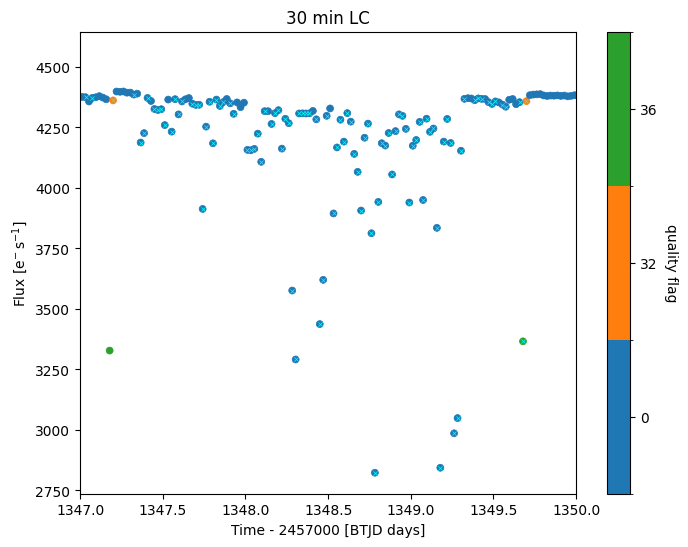

In [107]:
fig, ax = scatter_with_discrete_colorbar(x=lc30.time.value, 
                                         y=lc30.flux.value, 
                                         z=lc30.quality.value, 
                                         xlabel='Time', ylabel='Flux', 
                                         title='30 min LC',
                                         cmap_name='tab10', edgecolor=None, 
                                         s=(ms+2)**2,colorbar_title='quality flag')

lc30[qbin_30_C.loc[qbin_30_C['qmask']==bad].index.values].scatter(ax=ax,color='cyan',s=3**2,marker='x',label=None)
plt.show()


fig, ax = scatter_with_discrete_colorbar(x=lc30.time.value, 
                                         y=lc30.flux.value, 
                                         z=lc30.quality.value, 
                                         xlabel='Time', ylabel='Flux', 
                                         title='30 min LC',
                                         cmap_name='tab10', edgecolor=None, 
                                         s=(ms+2)**2,colorbar_title='quality flag')

lc30[qbin_30_C.loc[qbin_30_C['qmask']==bad].index.values].scatter(ax=ax,color='cyan',s=3**2,marker='x',label=None)
ax.set_xlim(1347,1350)
plt.show()

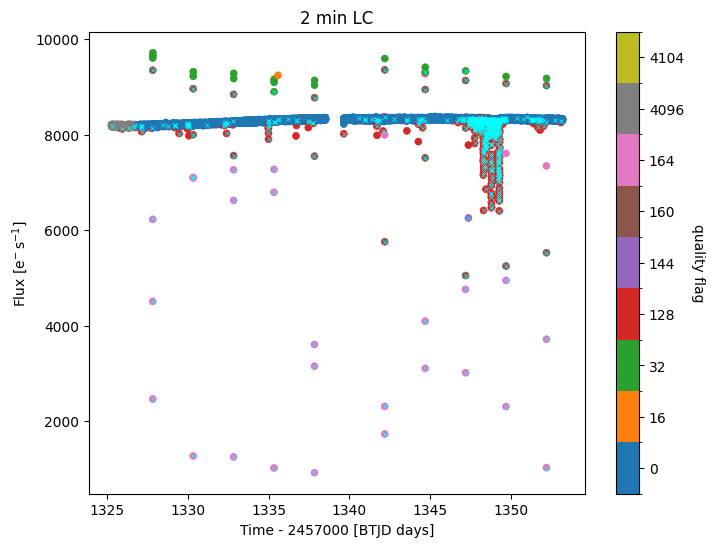

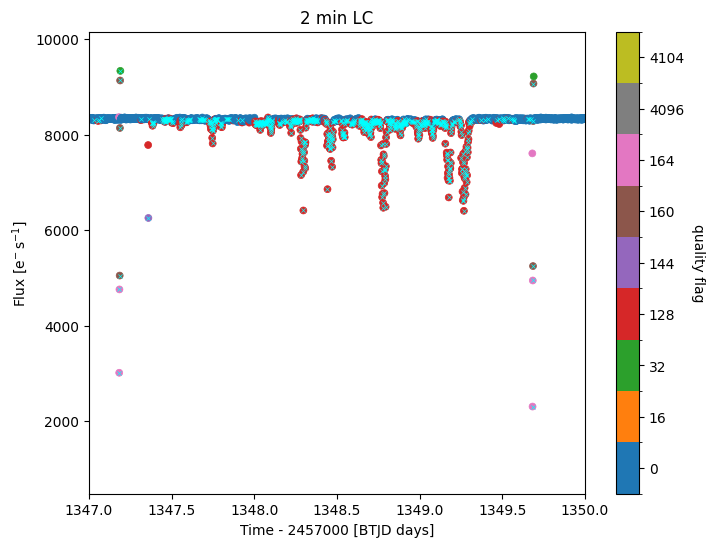

In [106]:
fig, ax = scatter_with_discrete_colorbar(x=lc2.time.value, 
                                         y=lc2.flux.value, 
                                         z=lc2.quality.value, 
                                         xlabel='Time', ylabel='Flux', 
                                         title='2 min LC',
                                         cmap_name='tab10', edgecolor=None, 
                                         s=(ms+2)**2,colorbar_title='quality flag')

lc2[qbin_2_C.loc[qbin_2_C['qmask']==bad].index.values].scatter(ax=ax,color='cyan',s=3**2,marker='x',label=None)
plt.show()


fig, ax = scatter_with_discrete_colorbar(x=lc2.time.value, 
                                         y=lc2.flux.value, 
                                         z=lc2.quality.value, 
                                         xlabel='Time', ylabel='Flux', 
                                         title='2 min LC',
                                         cmap_name='tab10', edgecolor=None, 
                                         s=(ms+2)**2,colorbar_title='quality flag')

lc2[qbin_2_C.loc[qbin_2_C['qmask']==bad].index.values].scatter(ax=ax,color='cyan',s=3**2,marker='x',label=None)
ax.set_xlim(1347,1350)
plt.show()

# This seems pretty close but not perfect....